# Siamese Bert!

sbert

## Carichiamo il dataset

In [13]:
import pandas as pd
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import numpy as np

#load pandas dataframe (rimuovo le righe vuote che putroppo sono presenti)
vax_series = pd.read_csv('data/posts_cleaned_it_only.csv')

vax_series.dropna(inplace=True)

#salviamo una lista di lista con le parole tokenizzate
#tokenized_sent = []
#for s in vax_series["clean_text"]:
    #print(word_tokenize(s))
   #tokenized_sent.append(word_tokenize(s) )
#print(tokenized_sent)

vax_text = vax_series['clean_text'].tolist()

vax_text


[nltk_data] Downloading package punkt to /home/apsev/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['pronta per affrontare la settimana quirinale 22 booster',
 "il pass sanitaire da guarigione non vale come booster. per questi pezzi di m.,3a dose sarebbe migliore dell'immunità di chi ha avuto il covid . e vogliono togliere la scadenza del spg per i tridosati, autorizzandoli ad infettare vita natural durante. arrestateli tutti. subito",
 'vaccino, il 29% dei bambini ha ricevuto almeno una dose in italia booster over 12 primo piano ultime notizie vaccino',
 "forza! noi stiamo un po' sereni e non sbrocchiamo in questo periodo perché abbiamo la certezza che siete lì e curate tutti, proprio tutti io vi sono sempre grata e riconoscente faccio la mia parte mi sono vaccinata booster fatelo tutti fate la vostra parte vaccino obbligatorio",
 'vaccinati con tredosi intera famiglia positiva covid19 influencer giornalisti politici virologi qualche commento in proposito? greenpass booster tamponi sivax novax stato emergenza',
 '"i giovani devono fare la dose booster, unico scudo contro omicron".'

## Caricamento del modello

Carichiamo il modello pre-addestrato 'distiluse-base-multilingual-cased-v1' Multi-Lingual model of Universal Sentence Encoder for 15 languages: Arabic, Chinese, Dutch, English, French, German, Italian, Korean, Polish, Portuguese, Russian, Spanish, Turkish.

In [14]:
#bert-base-nli-mean-tokens

from sentence_transformers import SentenceTransformer
sbert_model = SentenceTransformer('distiluse-base-multilingual-cased-v1')

## Creazione Embedding

Creiamo un vettore per ogni frase del dataset

In [15]:
#sentence_embeddings = sbert_model.encode(tokenized_sent[10])
sentence_embeddings = sbert_model.encode(vax_text)
print('Sample BERT embedding vector - length', len(sentence_embeddings[0]))
#print('Sample BERT embedding vector - note includes negative values', sentence_embeddings[0])

Sample BERT embedding vector - length 512


## Funzioni di pulizia

In questo caso usiamo lo stemming di snowball

In [16]:
#loading and cleaning dataset with spacy
import spacy
import pandas as pd
import regex as re
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
it_stopwords = stopwords.words('italian')

#the stemmer requires a language parameter
snow_stemmer = SnowballStemmer(language='italian')

def cleaner(s):
    #removing numbers and special caracters
    s = re.sub(r'[^a-z\s]', '', s).strip()
    #remving multiple spaces
    s = " ".join(s.split()).strip()
    #removing apostrophe and splititng words
    s = s.replace("'", " ")
    #some manual corrections
    #s = s.replace(' accino', ' vaccino')
    #removing stopwords with nltk
    s = stop_word_remover(s)
    #stemming with nltk
    s = stemmer(s)

    return s


def stop_word_remover(text):
    word_tokens = word_tokenize(text)
    word_list = [word for word in word_tokens if word.lower() not in it_stopwords]
    return " ".join(word_list)

def stemmer(text):
    words = word_tokenize(text)
    stem_words = [snow_stemmer.stem(word) for word in words]
    return " ".join(stem_words)
  
#query = "Tu apri il tuo armadio e scegli, non lo so, quel maglioncino azzurro infeltrito per esempio, perché vuoi gridare al mondo che ti prendi troppo sul serio per curarti di cosa ti metti addosso" 
#frase diavolo veste prada: 0.3 / 0.2
query = "i vaccini sono pericolosi hanno fatto morire tante persone"
#frase novax: 0.4
#cleaning
#query = cleaner(query)

print(query)


i vaccini sono pericolosi hanno fatto morire tante persone


[nltk_data] Downloading package stopwords to /home/apsev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Distanza dal centro del cluster con SBERT

Usiamo Kmeans per creare il cluster e ne determiniamo il centro. Successivamente calcoliamo la distanza di ogni frase dal centro del cluster.

In [17]:
import numpy as np
# k-means - Inertia as the number of clusters varies
from sklearn.cluster import KMeans
from sklearn import preprocessing  # to normalise existing X
from scipy.spatial.distance import cosine

#create a numpy array with all the vectors
vectors = np.zeros((len(sentence_embeddings), 512))
for i in range(len(sentence_embeddings)):
    vectors[i] = sentence_embeddings[i]

#normalize
vectors = preprocessing.normalize(vectors)

X_train = pd.DataFrame(vectors)

n_clusters = 1
n_init = 10
max_iter = 300
tol = 0.0001
random_state = 2018
# n_jobs = 2
kMeans_inertia = pd.DataFrame(data=[],index=range(2), \
columns=['inertia'])

kmeansfirst = KMeans(n_clusters=n_clusters, n_init=n_init, \
    max_iter=max_iter, tol=tol, random_state=random_state )
   
kmeansfirst.fit(X_train)

center = kmeansfirst.cluster_centers_
center.shape

print(kmeansfirst.score(vectors))

#calculate the distance between each point and the center
X_train['distance'] = X_train.apply(lambda x: cosine(x, center[0]), axis=1)

X_train["distance"].describe()
   

-13557.258225541385


count    19104.000000
mean         0.461164
std          0.148299
min          0.177492
25%          0.361479
50%          0.420196
75%          0.511904
max          1.096289
Name: distance, dtype: float64

## Test
Proviamo come la distanza dei vettori di anomalie e non anomalie varia.

In [27]:
#calculating the distance from the center
from gensim import similarities
from scipy.spatial.distance import cosine, euclidean
import spacy
import pandas as pd
import regex as re
import numpy as np


#definiziamo una lista di frasi che dovrebbero essere classificate come anomalie
anomalies = ["il cane gioca a palla","ho dovuto ripristinare il PC per togliere tutti i suoi malware", "bella giornata oggi", "una frase che parla di tutt'altro ma il modo lunghissimo per tentare di ingannare il caro amico use" ]
novax_sentences = ["i vaccini uccidono", "non mi voglio vaccinare", "no al vaccino", "non farò mai il booster", "dopo 4 dosi il sistema immunitario fritto", "i vaccini fanno morire le persone anche se ci dicono di no"]
#provo con un testo casuale
#testo = "i vaccini fanno morire le persone anche se ci dicono di no"
#test_vector = sbert_model.encode([anomalies])
#test_vector = model(testo)

cosine_distance = []
euclidean_distance = []
'''cosine_distance.append(  cosine(test_vector[0],center[0]) )
cosine_distance.append(  cosine(test_vector[0],center[1]) )
euclidean_distance.append (euclidean(test_vector[0],center[0]))
euclidean_distance.append(euclidean(test_vector[0],center[1]))

print("Distance score cosine 1 - 2:",cosine_distance[0],cosine_distance[1])
print("Distance score euclidean 1 - 2:",euclidean_distance[0],euclidean_distance[1])
print ("Euclidean distance sum:",sum(euclidean_distance))'''

print("Anomalies score:")
for i in anomalies:
   
    test_vector = sbert_model.encode([i])
    test_vector_norm = preprocessing.normalize(test_vector)

    cosine_distance = cosine(test_vector[0],center[0])
    euclidean_distance = euclidean(test_vector[0],center[0])

    #cosine_distance_norm = cosine(test_vector_norm[0],center[0])
    #euclidean_distance_norm = euclidean(test_vector_norm[0],center[0])
   
    print ("Cosine:",cosine_distance)


print("Novax score:")
for i in novax_sentences:
    test_vector = sbert_model.encode([i])
    test_vector_norm = preprocessing.normalize(test_vector)

    cosine_distance = cosine(test_vector[0],center[0])
    euclidean_distance = euclidean(test_vector[0],center[0])

    #cosine_distance_norm = cosine(test_vector_norm[0],center[0])
    #euclidean_distance_norm = euclidean(test_vector_norm[0],center[0])
   
    print ("Cosine:",cosine_distance)
    #print ("Cosine norm:",cosine_distance_norm,"Euclidean norm: ",cosine_distance_norm)

Anomalies score:
Cosine: 0.9945567857301324
Cosine: 0.7886830584412956
Cosine: 0.9652166408619733
Cosine: 0.9260961465733119
Novax score:
Cosine: 0.34597523165638133
Cosine: 0.3824881443677176
Cosine: 0.3861222770442061
Cosine: 0.8720778624599448
Cosine: 0.6634075722739347
Cosine: 0.291304792296342


## PCA + Kmeans

In [19]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np
 
#Load Data
data = sentence_embeddings
pca = PCA(2)
 
#Transform the data
df = pca.fit_transform(data)
 
df.shape

#Initialize the class object
kmeans2 = KMeans(n_clusters= 1)
 
#predict the labels of clusters.
label = kmeans2.fit_predict(df)
 
print(label)

[0 0 0 ... 0 0 0]


/home/apsev/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


## Visualizzazione cluster con PCA

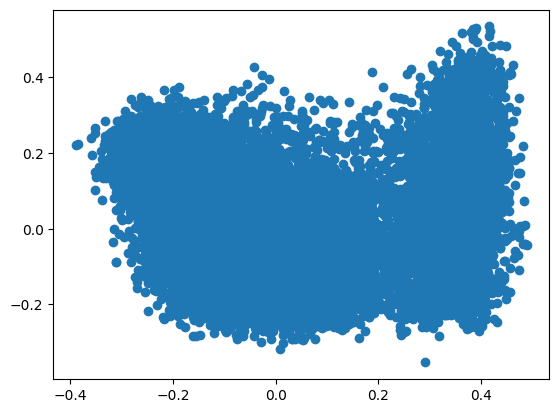

In [20]:
import matplotlib.pyplot as plt
 
#filter rows of original data
filtered_label0 = df[label == 0]
 
#plotting the results
plt.scatter(filtered_label0[:,0] , filtered_label0[:,1])
plt.show()

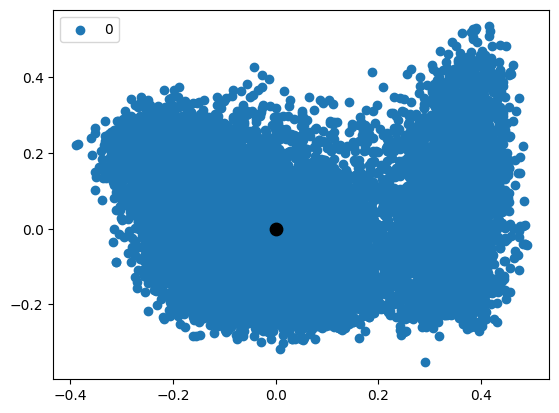

In [23]:
#Getting the Centroids
centroids = kmeans2.cluster_centers_
u_labels = np.unique(label)
 
#plotting the results:
 
for i in u_labels:
    plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
plt.legend()
plt.show()

In [33]:
#calculating the distance from the center
from gensim import similarities
from scipy.spatial.distance import cosine, euclidean
import spacy
import pandas as pd
import regex as re
import numpy as np

pca = PCA(2)
df = pca.fit_transform(data)

#definiziamo una lista di frasi che dovrebbero essere classificate come anomalie
anomalies = ["il cane gioca a palla","ho dovuto ripristinare il PC per togliere tutti i suoi malware", "bella giornata oggi", "una frase che parla di tutt'altro ma il modo lunghissimo per tentare di ingannare il caro amico use" ]
novax_sentences = ["i vaccini uccidono", "non mi voglio vaccinare", "no al vaccino", "non farò mai il booster", "dopo 4 dosi il sistema immunitario fritto", "i vaccini fanno morire le persone anche se ci dicono di no"]
#provo con un testo casuale
#testo = "i vaccini fanno morire le persone anche se ci dicono di no"
#test_vector = sbert_model.encode([anomalies])
#test_vector = model(testo)

cosine_distance = []
euclidean_distance = []
'''cosine_distance.append(  cosine(test_vector[0],center[0]) )
cosine_distance.append(  cosine(test_vector[0],center[1]) )
euclidean_distance.append (euclidean(test_vector[0],center[0]))
euclidean_distance.append(euclidean(test_vector[0],center[1]))

print("Distance score cosine 1 - 2:",cosine_distance[0],cosine_distance[1])
print("Distance score euclidean 1 - 2:",euclidean_distance[0],euclidean_distance[1])
print ("Euclidean distance sum:",sum(euclidean_distance))'''

print("Anomalies score:")
for i in anomalies:
 
    test_vector = sbert_model.encode([i])
    test_vector = pca.transform(test_vector)
    test_vector_norm = preprocessing.normalize(test_vector)

    cosine_distance = cosine(test_vector[0],centroids[0])
    euclidean_distance = euclidean(test_vector[0],centroids[0])

    #cosine_distance_norm = cosine(test_vector_norm[0],center[0])
    #euclidean_distance_norm = euclidean(test_vector_norm[0],center[0])
   
    print ("Cosine:",cosine_distance)


print("Novax score:")
for i in novax_sentences:
    test_vector = sbert_model.encode([i])
    test_vector = pca.transform(test_vector)
    test_vector_norm = preprocessing.normalize(test_vector)

    cosine_distance = cosine(test_vector[0],centroids[0])
    euclidean_distance = euclidean(test_vector[0],centroids[0])

    #cosine_distance_norm = cosine(test_vector_norm[0],center[0])
    #euclidean_distance_norm = euclidean(test_vector_norm[0],center[0])
   
    print ("Cosine:",cosine_distance)
    #print ("Cosine norm:",cosine_distance_norm,"Euclidean norm: ",cosine_distance_norm)

Anomalies score:
Cosine: 1.4710050523281097
Cosine: 1.0822100266814232
Cosine: 1.6589168310165405
Cosine: 1.628216803073883
Novax score:
Cosine: 0.003350496292114258
Cosine: 0.011122286319732666
Cosine: 0.02475970983505249
Cosine: 1.2370922267436981
Cosine: 0.7954058349132538
Cosine: 0.029509127140045166


: 